# Giffler-Thompson Algorithmus

In [1]:
# Datenzugriff
from configs.path_manager import get_path
import json

# Utils
from src.utils import convert
import src.utils.visualization.gantt_diagram as gantt
from src.utils.initialization import jobs_jssp_init as init
from src.utils.analysis_basics import check_constrains as check

In [3]:
import time

In [4]:
basic_data_path = get_path("data", "basic")

In [5]:
# Datei laden
basic_data_path = get_path("data", "basic")
file_path = basic_data_path / "jobshop_instances.json"

with open(file_path, "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
df_instance = convert.jssp_dict_to_df(instance)
df_production_orders = init.production_orders(df_instance)
df_production_orders 

,Job,Production_Plan_ID,Operation,Machine,Processing Time
0,0,0,0,M00,29
1,0,0,1,M01,78
2,0,0,2,M02,9
3,0,0,3,M03,36
4,0,0,4,M04,49
...,...,...,...,...,...
95,9,9,5,M09,76
96,9,9,6,M05,47
97,9,9,7,M03,52
98,9,9,8,M04,90


1. **Initialisierung**:

   * Setze Startzeit jedes Jobs und Maschinenverfügbarkeit auf 0.
   * Markiere erste Operation jedes Jobs als „bereit zur Planung“.

2. **Solange noch nicht alle Operationen eingeplant sind**:

   1. Bestimme für jede verfügbare Operation die **frühestmögliche Startzeit** (unter Berücksichtigung von Maschinenverfügbarkeit und Vorgängeroperationen).
   2. Wähle die Operation mit dem **frühesten frühestmöglichen Endzeitpunkt** (**Earliest Completion Time**, ECT).
   3. Identifiziere die **Konfliktmenge**: alle anderen Operationen, die auf derselben Maschine zum gleichen Zeitpunkt starten könnten.
   4. **Wähle eine Operation** aus der Konfliktmenge nach einer **Prioritätsregel** (z. B. SPT – Shortest Processing Time).
   5. **Plane diese Operation ein**:

      * Weise ihr Start- und Endzeit zu.
      * Aktualisiere Maschinenverfügbarkeit.
      * Markiere die Nachfolgeoperation im Job als „bereit“, wenn möglich.

3. **Wiederholen**, bis alle Operationen eingeplant sind.

In [6]:
from collections import defaultdict
import pandas as pd
import random


def giffler_thompson_schedule(df_jssp: pd.DataFrame,
                               job_column: str = "Job",
                               priority_rule: str = "SPT",
                               log_on: bool = True) -> pd.DataFrame:
    """
    Giffler-Thompson-Algorithmus zur Erstellung eines zulässigen JSSP-Zeitplans.

    Parameter:
    - df_jssp: DataFrame mit Spalten [job_column, 'Operation', 'Machine', 'Processing Time']
    - job_column: Name der Spalte, die den Job bzw. Auftrag identifiziert (Standard: 'Production_Order_ID')
    - priority_rule: "SPT", "LPT", "FCFS" oder "RANDOM"
    - log_on: Ob Fortschrittsinformationen ausgegeben werden sollen

    Rückgabe:
    - df_schedule: DataFrame mit [job_column ,'Operation','Machine','Start','Processing Time','End']
    """
    starting_time = time.time()
    if log_on: 
        print(f'Giffler-Thompson-Algorithmus mit Prioritätsregel "{priority_rule}" gestartet ...\n')
    
    # Vorbereitung
    df = df_jssp.copy().sort_values([job_column, 'Operation']).reset_index(drop=True)
    machines = set(df['Machine'])
    jobs = df[job_column].unique()

    # Zeitstatus
    job_op_ready = {job: 0 for job in jobs}
    machine_available = {m: 0 for m in machines}
    job_op_index = {job: 0 for job in jobs}

    # Operationen vorbereiten
    job_ops = defaultdict(list)
    for _, row in df.iterrows():
        job_ops[row[job_column]].append((row['Operation'], row['Machine'], row['Processing Time']))

    result = []
    remaining = sum(len(v) for v in job_ops.values())

    while remaining > 0:
        candidates = []
        for job in jobs:
            idx = job_op_index[job]
            if idx < len(job_ops[job]):
                op_id, m, d = job_ops[job][idx]
                est = max(job_op_ready[job], machine_available[m])
                candidates.append((est, d, job, op_id, m))

        min_est = min(c[0] for c in candidates)
        conflict_ops = [c for c in candidates if c[0] == min_est]

        # Wähle nach Prioritätsregel
        if priority_rule == "SPT":
            selected = min(conflict_ops, key=lambda x: x[1])
        elif priority_rule == "LPT":
            selected = max(conflict_ops, key=lambda x: x[1])
        elif priority_rule == "FCFS":
            selected = conflict_ops[0]
        else:  # RANDOM
            selected = random.choice(conflict_ops)

        est, d, job, op_id, m = selected
        start = est
        end = start + d
        result.append({
            job_column: job,
            'Operation': op_id,
            'Machine': m,
            'Start': start,
            'Processing Time': d,
            'End': end
        })

        job_op_ready[job] = end
        machine_available[m] = end
        job_op_index[job] += 1
        remaining -= 1

    solving_duration = time.time() - starting_time
    df_schedule = pd.DataFrame(result).sort_values(['Start', job_column, 'Operation']).reset_index(drop=True)
    makespan = df_schedule['End'].max()

    # Logging
    if log_on:
        print("\nPlan-Informationen:")
        print(f"  Anzahl Jobs        : {len(jobs)}")
        print(f"  Anzahl Maschinen   : {len(machines)}")
        print(f"  Anzahl Operationen : {len(df_schedule)}")
        print(f"  Makespan           : {makespan}")
        print(f"  Laufzeit           : ~{solving_duration:.2f} Sekunden")

    return df_schedule



### a) SPT

In [7]:
# Scheduling
df_schedule = giffler_thompson_schedule(df_production_orders, priority_rule="SPT")
df_schedule

Giffler-Thompson-Algorithmus mit Prioritätsregel "SPT" gestartet ...


Plan-Informationen:
  Anzahl Jobs        : 10
  Anzahl Maschinen   : 10
  Anzahl Operationen : 100
  Makespan           : 1074
  Laufzeit           : ~0.00 Sekunden


,Job,Operation,Machine,Start,Processing Time,End
0,0,0,M00,0,29,29
1,4,0,M02,0,14,14
2,6,0,M01,0,46,46
3,7,0,M02,14,31,45
4,4,1,M00,29,6,35
...,...,...,...,...,...,...
95,3,9,M05,943,43,986
96,7,9,M03,943,79,1022
97,9,9,M07,943,45,988
98,2,8,M09,996,45,1041


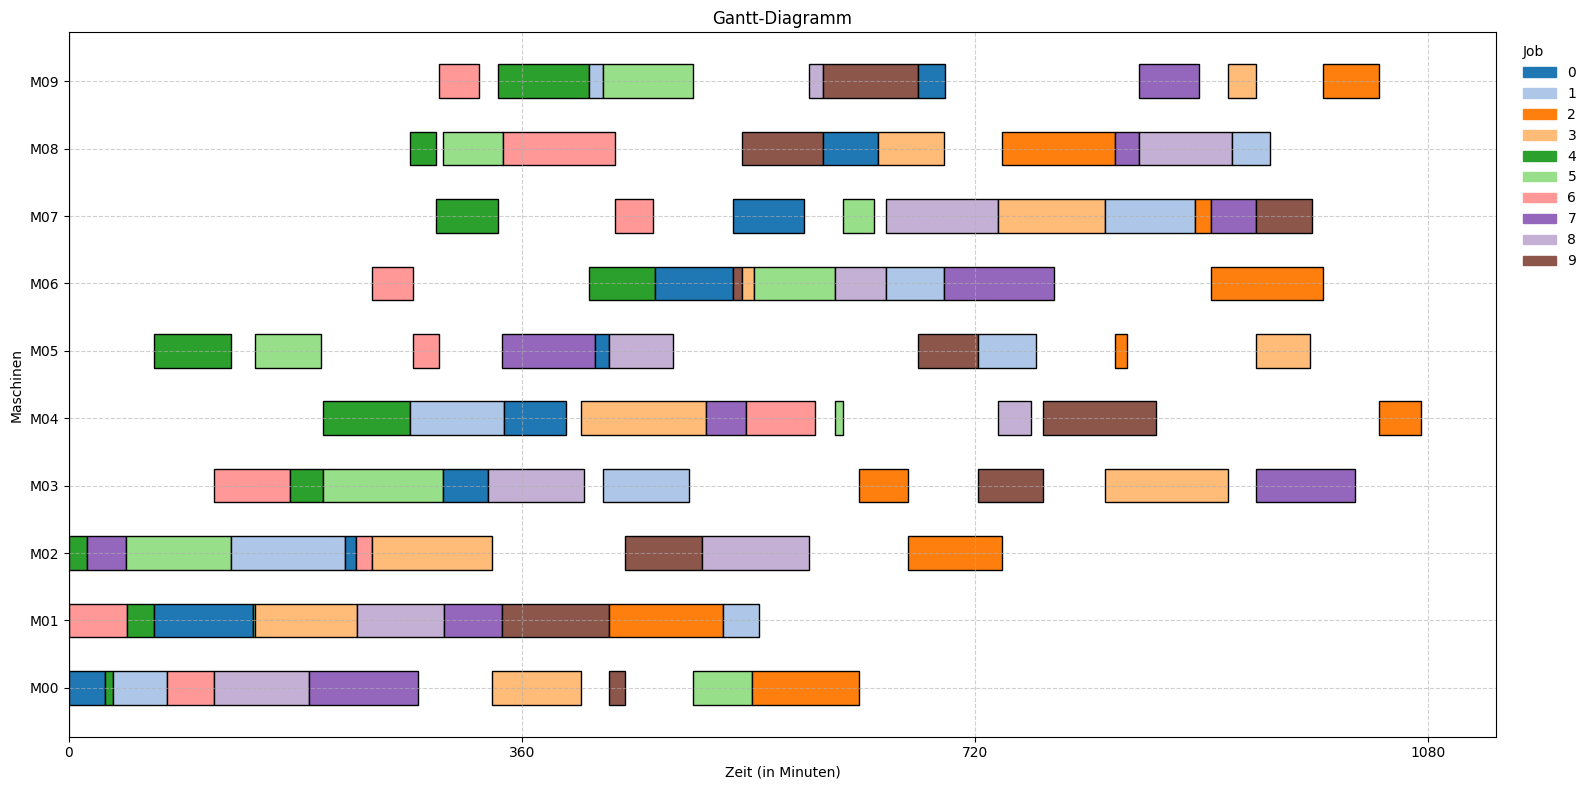

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.


True

In [8]:
gantt.get_plot(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)

### b) FCFS

In [9]:
# Scheduling
df_schedule = giffler_thompson_schedule(df_production_orders, priority_rule="FCFS")
df_schedule

Giffler-Thompson-Algorithmus mit Prioritätsregel "FCFS" gestartet ...


Plan-Informationen:
  Anzahl Jobs        : 10
  Anzahl Maschinen   : 10
  Anzahl Operationen : 100
  Makespan           : 1262
  Laufzeit           : ~0.00 Sekunden


,Job,Operation,Machine,Start,Processing Time,End
0,0,0,M00,0,29,29
1,2,0,M01,0,91,91
2,4,0,M02,0,14,14
3,5,0,M02,14,84,98
4,1,0,M00,29,43,72
...,...,...,...,...,...,...
95,9,7,M03,1075,52,1127
96,8,8,M04,1093,26,1119
97,8,9,M08,1119,74,1193
98,9,8,M04,1127,90,1217


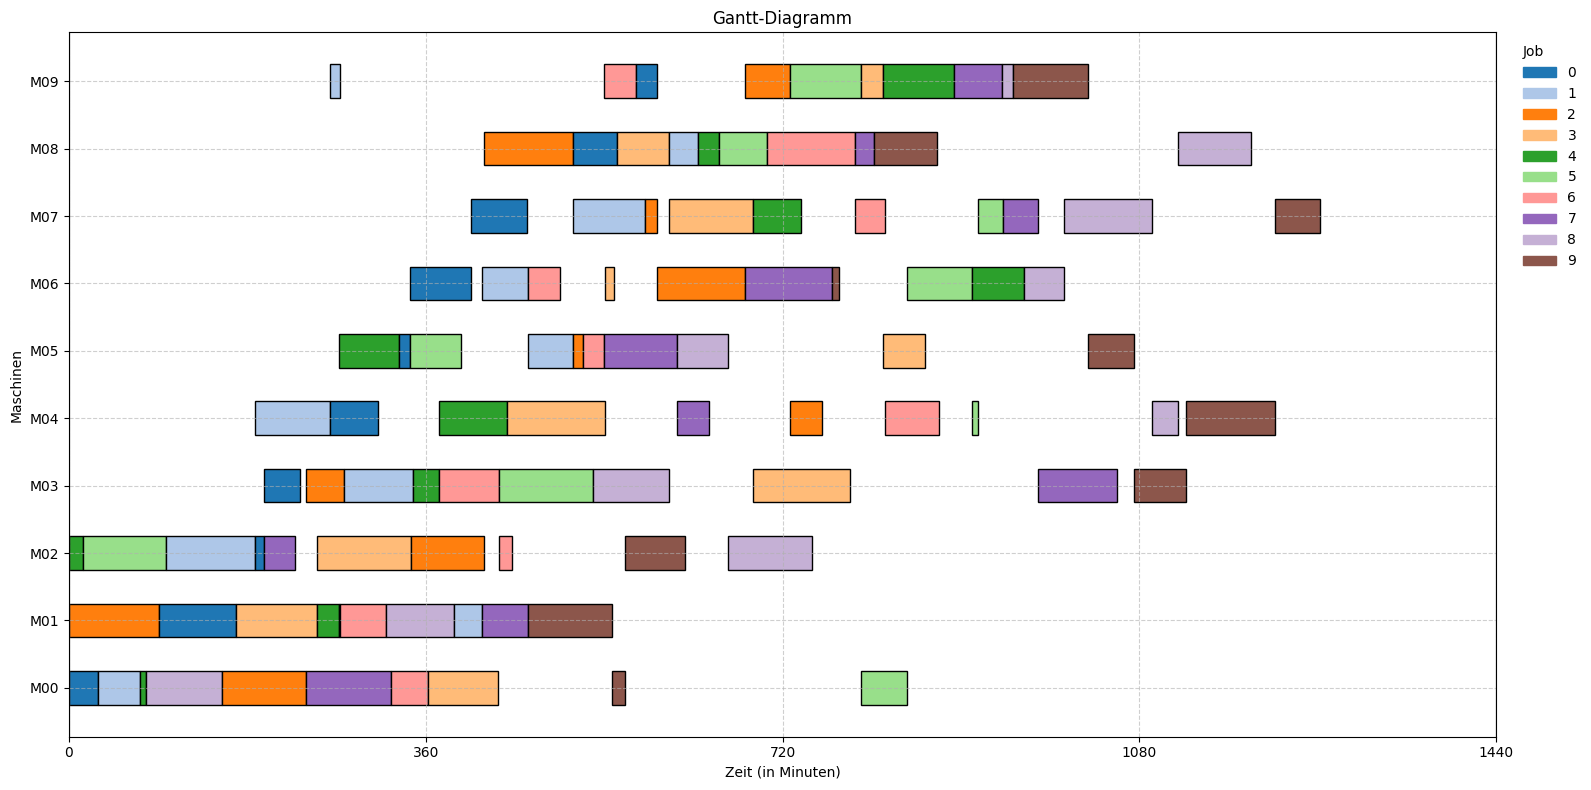

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.


True

In [10]:
gantt.get_plot(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)

### c) LPT

In [11]:
# Scheduling
df_schedule = giffler_thompson_schedule(df_production_orders, priority_rule="LPT")
df_schedule

Giffler-Thompson-Algorithmus mit Prioritätsregel "LPT" gestartet ...


Plan-Informationen:
  Anzahl Jobs        : 10
  Anzahl Maschinen   : 10
  Anzahl Operationen : 100
  Makespan           : 1295
  Laufzeit           : ~0.00 Sekunden


,Job,Operation,Machine,Start,Processing Time,End
0,2,0,M01,0,91,91
1,5,0,M02,0,84,84
2,8,0,M00,0,76,76
3,1,0,M00,76,43,119
4,7,0,M02,84,31,115
...,...,...,...,...,...,...
95,2,8,M09,1186,45,1231
96,5,7,M06,1186,65,1251
97,2,9,M04,1231,33,1264
98,5,8,M04,1264,6,1270


### d) Random

In [12]:
# Scheduling
df_schedule = giffler_thompson_schedule(df_production_orders, priority_rule="RANDOM")
df_schedule

Giffler-Thompson-Algorithmus mit Prioritätsregel "RANDOM" gestartet ...


Plan-Informationen:
  Anzahl Jobs        : 10
  Anzahl Maschinen   : 10
  Anzahl Operationen : 100
  Makespan           : 1274
  Laufzeit           : ~0.00 Sekunden


,Job,Operation,Machine,Start,Processing Time,End
0,0,0,M00,0,29,29
1,2,0,M01,0,91,91
2,5,0,M02,0,84,84
3,8,0,M00,29,76,105
4,4,0,M02,84,14,98
...,...,...,...,...,...,...
95,9,8,M04,1111,90,1201
96,4,9,M06,1127,53,1180
97,9,9,M07,1201,45,1246
98,3,8,M09,1209,22,1231
